# Pinecone-Multimodal.ipynb

- Author: [ro__o_jun](https://github.com/ro-jun)
- Design: []()
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/01-OpenAIEmbeddings.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/01-OpenAIEmbeddings.ipynb)

## Overview

This tutorial demonstrates how to integrate Pinecone with LangChain for multimodal tasks, such as image and text embeddings, leveraging OpenCLIP for embedding generation.   

We cover setting up a Pinecone index, processing multimodal datasets, and efficiently uploading vectors with parallelism. Additionally, we explore how to perform text-based and image-based searches using the Pinecone index.   

By the end of this guide, you'll be able to build a scalable and efficient multimodal vector search system.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Using multimodal](#Using-multimodal)

### References

- [Langchain-OpenClip](https://python.langchain.com/docs/integrations/text_embedding/open_clip/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain-pinecone",
        "pinecone[grpc]",
        "langchain_community",
        "langchain-openai",
        "pinecone-text",
        "langchain-huggingface",
        "open_clip_torch",
        "langchain-experimental",
        "pillow",
        "matplotlib",
        "datasets >= 3.2.0",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "PINECONE_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Pinecone",
        "HUGGINGFACEHUB_API_TOKEN": "",
    },
)

Environment variables have been set successfully.


[Note] If you are using a `.env` file, proceed as follows.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Using multimodal

We will use the `datasets` library to load a sample dataset and process it for embedding generation.

In [ ]:
from utils.pinecone import PineconeDocumentManager
import os

multimodal_pc = PineconeDocumentManager(
    api_key=os.getenv("PINECONE_API_KEY"),
)

### Step 1: Load and Save Dataset Images Temporarily

The dataset we use here includes images and associated metadata (e.g., prompts and categories). The images are saved temporarily for embedding generation.

Image Path: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmppxen5rk3.png
Prompt: a rabbit lying on a soft blanket, warm indoor lighting, cozy atmosphere, highly detailed, 8k resolution.
Category: rabbit


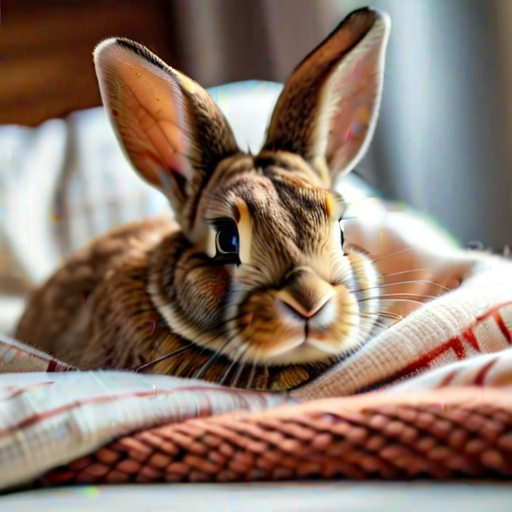

In [6]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("Pupba/animal-180", split="train")

# Process first 50 images
images = dataset[:50]["png"]
image_paths = [multimodal_pc.save_temp_image(img) for img in images]
metas = dataset[:50]["json"]
prompts = [data["prompt"] for data in metas]
categories = [data["category"] for data in metas]

print("Image Path:", image_paths[10])
print("Prompt:", prompts[10])
print("Category:", categories[10])
images[10]

### Step 2: Loading OpenCLIP for Embedding Generation

OpenCLIP will be used to generate embeddings for both images and text.

In [7]:
import open_clip

open_clip.list_pretrained()[-5:]

[('ViT-L-14-336-quickgelu', 'openai'),
 ('ViT-H-14-quickgelu', 'metaclip_fullcc'),
 ('ViT-H-14-quickgelu', 'dfn5b'),
 ('ViT-H-14-378-quickgelu', 'dfn5b'),
 ('ViT-bigG-14-quickgelu', 'metaclip_fullcc')]

In [8]:
# Load OpenCLIP model
model = "ViT-H-14-378-quickgelu"
checkpoint = "dfn5b"

image_embedding = multimodal_pc._initialize_openclip(
    model_name=model,
    checkpoint=checkpoint,
)

[INFO] OpenCLIP model initialized.


### Step 3: Create Pinecone Index for Multimodal Data

We create a Pinecone index to store image embeddings. This index will later be used for searching.

In [9]:
from pinecone import ServerlessSpec, PodSpec

# Create or reuse the index
index_name = "langchain-opentutorial-multimodal-1024"

# Set to True when using the serverless method, and False when using the PodSpec method.
use_serverless = True
if use_serverless:
    spec = ServerlessSpec(cloud="aws", region="us-east-1")
else:
    spec = PodSpec(environment="us-west1-gcp", pod_type="p1.x1", pods=1)

multimodal_pc.create_index(
    index_name=index_name,
    dimension=1024,
    metric="dotproduct",
    spec=spec
)
index = multimodal_pc.get_index(index_name)

Using existing index: langchain-opentutorial-multimodal-1024


![04-pinecone-multimodal-index.png](./assets/04-pinecone-multimodal-02.png)

### Step 4: Uploading Data to Pinecone

We will vectorize the dataset images using OpenCLIP and upload them to the Pinecone index.

In [10]:
index_name = "langchain-opentutorial-multimodal-1024"
namespace = "Pupba-animal-180"
vectors = []


multimodal_pc.upload_images(
    index=index,
    image_paths=image_paths,
    prompts=prompts,
    categories=categories,
    image_embedding=image_embedding,
    namespace=namespace,
)

Processing Images: 100%|██████████| 50/50 [05:12<00:00,  6.26s/it]


Uploaded 50 images to Pinecone.


![04-pinecone-multimodal-data.png](./assets/04-pinecone-multimodal-01.png)

### Step 5: Batch Processing for Large Datasets

To handle larger datasets, batch processing with parallelism can be used for faster uploads.


In [10]:
BATCH_SIZE = 32
MAX_WORKERS = 8
namespace = "Pupba-animal-180-batch-workers"

processor = multimodal_pc.upsert_images_parallel(
    index=index,
    image_paths=image_paths,
    prompts=prompts,
    categories=categories,
    image_embedding=image_embedding,
    namespace=namespace,
    batch_size=BATCH_SIZE,
    max_workers=MAX_WORKERS,
)

Uploading image batches: 100%|██████████| 2/2 [04:56<00:00, 148.41s/it]

Uploaded 50 images to Pinecone.


![04-pinecone-multimodal-03.png](./assets/04-pinecone-multimodal-03.png)

### Step 6: Search by Text or Image

Now that the data is uploaded, we can perform searches based on text or images.

**Text-Based Search**

Text Query: a running elephant
Category: elephant, Prompt: a majestic elephant walking through the savanna, golden sunlight illuminating its wrinkled skin, highly detailed, 8k resolution., Score: 0.36785552
Category: elephant, Prompt: a baby elephant exploring its surroundings, soft sunlight, highly detailed, photorealistic, adorable and realistic., Score: 0.365934
Category: elephant, Prompt: an elephant walking through a dusty savanna, soft natural lighting, highly detailed, photorealistic, natural textures., Score: 0.36491212
Category: elephant, Prompt: an elephant walking through tall grass, golden sunlight reflecting off its skin, highly detailed, natural lighting, ultra-realistic., Score: 0.35923028
Category: elephant, Prompt: an elephant spraying water with its trunk, playful expression, soft natural lighting, highly detailed, 8k resolution., Score: 0.34974286


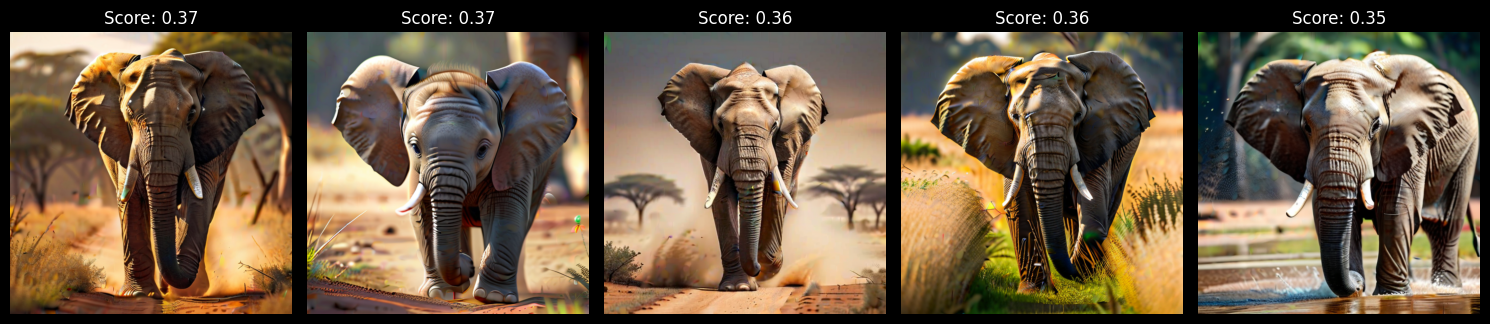

In [ ]:
namespace="Pupba-animal-180-batch-workers"

results_text = multimodal_pc.search_by_text(
    index=index,
    query="a running elephant",
    clip_embedder=image_embedding,
    namespace=namespace,
    top_k=5,
    local_image_paths=image_paths,
)

**Image-Based Search**

Image Query: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpi8jqw32x.png
Category: rabbit, Prompt: a fluffy white rabbit sitting in a grassy meadow, soft sunlight illuminating its fur, highly detailed, 8k resolution., Score: 1.0000001
Category: rabbit, Prompt: a rabbit playing in a meadow, soft sunlight, vibrant colors, highly detailed, ultra-realistic, 8k resolution., Score: 0.95482814
Category: rabbit, Prompt: a rabbit hopping through a grassy field, soft moonlight, white colors, highly detailed, photorealistic, 8k resolution., Score: 0.9535866
Category: rabbit, Prompt: a rabbit hopping through a grassy field, soft sunlight, vibrant colors, highly detailed, photorealistic, 8k resolution., Score: 0.94812655
Category: rabbit, Prompt: a rabbit hopping through a grassy field, soft sunlight, vibrant colors, highly detailed, photorealistic, 8k resolution., Score: 0.94812655


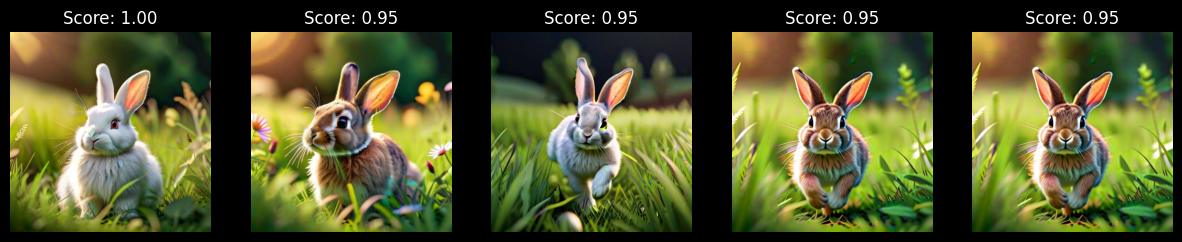

In [17]:
namespace="Pupba-animal-180-batch-workers"

results_image = multimodal_pc.search_by_image(
    index=index,
    img_path=image_paths[0],
    clip_embedder=image_embedding,
    namespace=namespace,
    top_k=5,
    local_image_paths=image_paths,
)